# Exploration into Thickness

In [62]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from nba_api.stats.endpoints import LeagueHustleStatsPlayer

pd.set_option('display.max_columns', 100)

In [124]:
# Load DataFrame of thickness metrics
with open('thick_df.p', 'rb') as f:
    thick_df = pickle.load(f)

In [125]:
# Organize DataFrame for EDA
thick_df.drop(columns=['avg_weight', 'STAR', 'predicted_weight', 'STAAR', 'TAR', 'TAAR', 'PTAAR', 'diff'], inplace=True)
thick_df = thick_df.rename(columns={
    'player_name': 'Name',
    'team_abbreviation': 'Team',
    'player_height_inches': 'Height',
    'player_weight': 'Weight',
    'new_pw': 'Expected Weight',
    'new_STAAR': 'STAAR',
})

In [120]:
# Get hustle stats from NBA API
hustle = LeagueHustleStatsPlayer(season='2019-20').get_data_frames()[0]

In [126]:
# Organize DataFrame
hdf = hustle.drop(columns=['PLAYER_ID', 'TEAM_ID'])
hdf.columns = [ ' '.join(col.split('_')).capitalize() for col in hdf.columns ]
hdf = hdf.rename(columns={
    'Player name': 'Name',
    'Team abbreviation': 'Team',
})

In [127]:
# Set stats columns for correlation
stats = [ col for col in hdf.columns if col not in ['Name', 'Team', 'Age'] ]

In [128]:
# Merge DataFrames
df = pd.merge(thick_df, hdf, on=['Name', 'Team'])

## Initial EDA

In [153]:
df.head()

,Name,Team,Height,Weight,Expected Weight,STAAR,Age,G,Min,Contested shots,Contested shots 2pt,Contested shots 3pt,Deflections,Charges drawn,Screen assists,Screen ast pts,Off loose balls recovered,Def loose balls recovered,Loose balls recovered,Pct loose balls recovered off,Pct loose balls recovered def,Off boxouts,Def boxouts,Box out player team rebs,Box out player rebs,Box outs,Pct box outs off,Pct box outs def,Pct box outs team reb,Pct box outs reb
0,Aaron Gordon,ORL,80,235,226.284954,0.5639,24.0,62,2017.0,330,209,121,63,1,55,119,33,34,67,0.493,0.507,14,53,39,21,67,0.209,0.791,0.929,0.500
1,Aaron Holiday,IND,72,185,183.157289,0.1488,23.0,66,1617.0,413,196,217,111,3,13,31,22,24,46,0.478,0.522,2,66,41,5,68,0.029,0.971,0.719,0.088
2,Abdel Nader,OKC,77,225,208.890286,1.1270,26.0,55,867.0,223,127,96,54,0,7,16,12,17,29,0.414,0.586,0,43,20,6,43,0.000,1.000,0.714,0.214
3,Adam Mokoka,CHI,77,190,208.890286,-1.3171,21.0,11,112.0,14,4,10,10,0,1,2,2,1,3,0.667,0.333,3,6,4,2,9,0.333,0.667,1.000,0.500
4,Admiral Schofield,WAS,77,241,208.890286,2.2443,23.0,33,368.0,82,51,31,15,1,23,53,5,4,9,0.556,0.444,1,37,15,4,38,0.026,0.974,0.833,0.222


### Regressions

In [142]:
# Helper function
def regression_(feature, target):
    X = np.array(df[feature]).reshape((-1,1))
    y = df[target]
    h_range = np.arange(df[feature].min(), df[feature].max() + 1).reshape((-1,1))
    
    transformer = PolynomialFeatures(degree=2)
    X_ = transformer.fit_transform(X)
    h_range_ = transformer.fit_transform(h_range)
    
    model = LinearRegression()
    model.fit(X_, y)
    score = round(model.score(X_, y), 4)
    reg_line = model.predict(h_range_)
    
    return h_range, reg_line, score

# Plot function
def plot_regression(feature, target):
    h_range, reg_line, score = regression_(feature, target)
    plt.plot(h_range, reg_line, color='red')
    plt.scatter(df[feature], df[target])
    plt.title(f'{target} vs. {feature} with Regression, r-score: {score}')
    
    return plt.show()

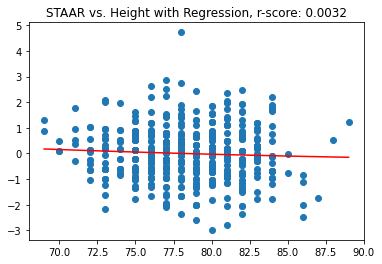

In [143]:
plot_regression('Height', 'STAAR')

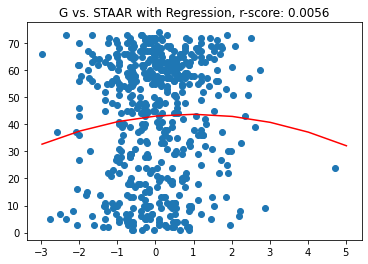

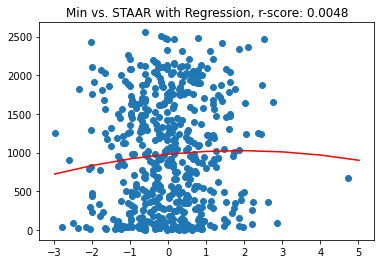

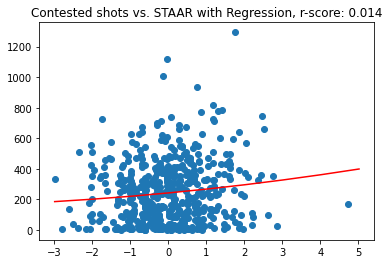

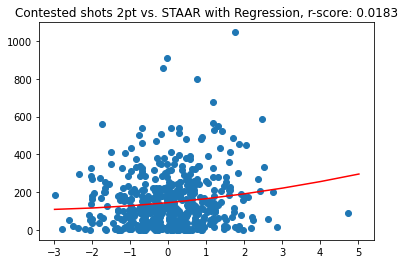

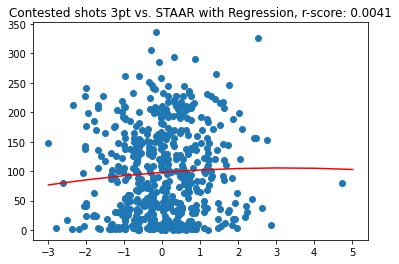

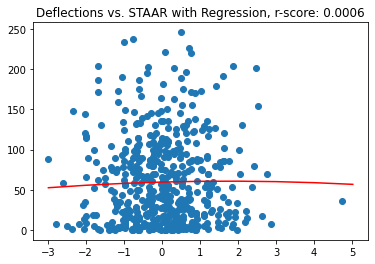

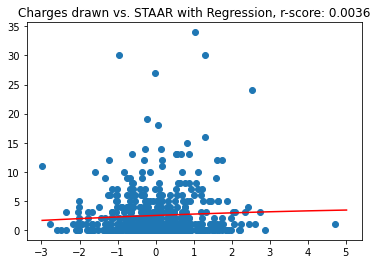

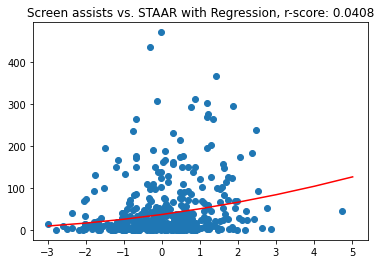

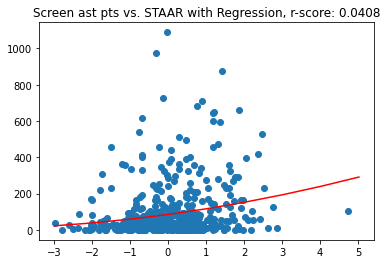

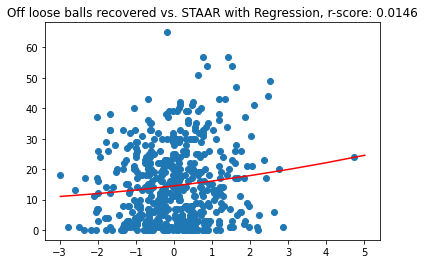

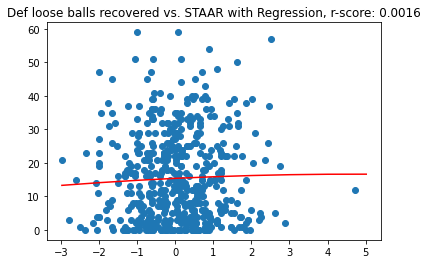

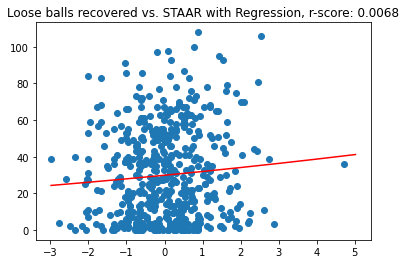

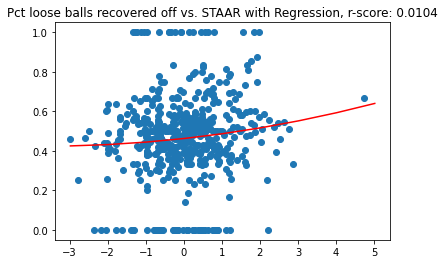

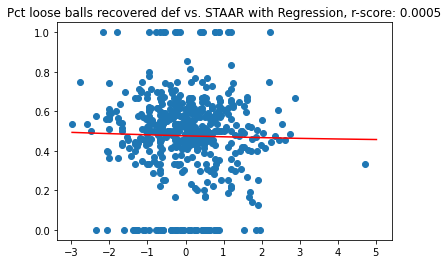

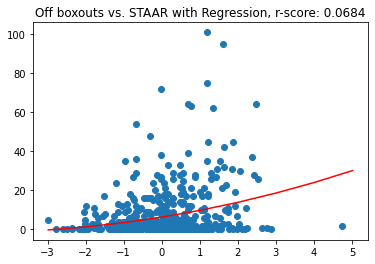

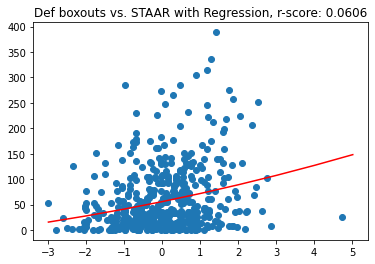

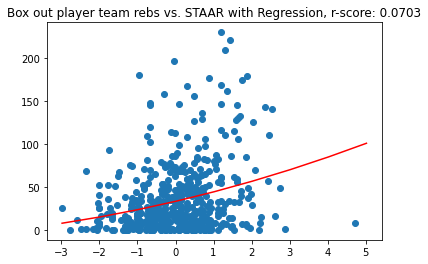

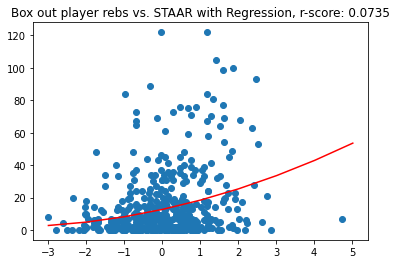

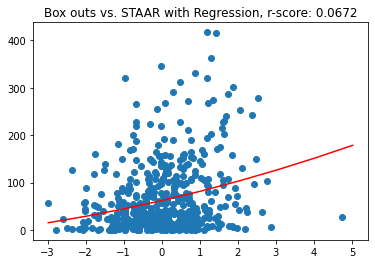

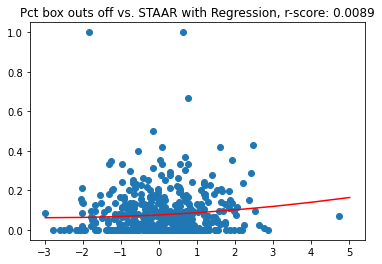

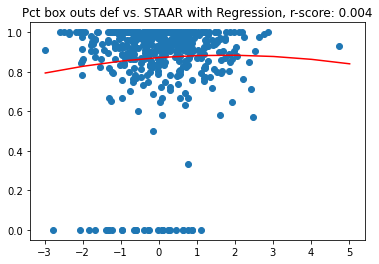

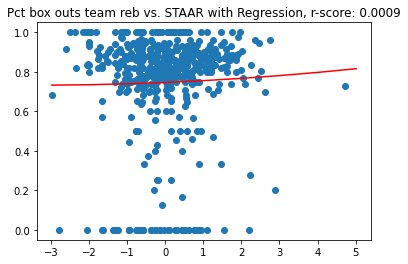

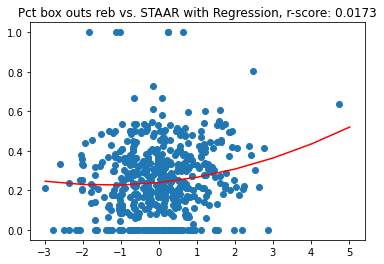

In [136]:
for col in stats:
    plot_regression('STAAR', col)

In [140]:
df.corr()

,Height,Weight,Expected Weight,STAAR,Age,G,Min,Contested shots,Contested shots 2pt,Contested shots 3pt,Deflections,Charges drawn,Screen assists,Screen ast pts,Off loose balls recovered,Def loose balls recovered,Loose balls recovered,Pct loose balls recovered off,Pct loose balls recovered def,Off boxouts,Def boxouts,Box out player team rebs,Box out player rebs,Box outs,Pct box outs off,Pct box outs def,Pct box outs team reb,Pct box outs reb
Height,1.000000,0.778377,0.998028,-0.056660,-0.019371,0.014064,-0.018110,0.314381,0.437504,0.005077,-0.075396,-0.066579,0.509959,0.510067,0.021432,-0.139657,-0.063925,0.163762,-0.124698,0.459632,0.466568,0.462839,0.501600,0.485017,0.332482,-0.091353,0.139988,0.459089
Weight,0.778377,1.000000,0.779720,0.578812,0.076354,0.046937,0.026502,0.337875,0.451950,0.040415,-0.046779,-0.014789,0.557685,0.557382,0.097510,-0.088934,0.001945,0.195383,-0.118694,0.551882,0.542966,0.554546,0.589980,0.567427,0.330951,-0.043704,0.132516,0.449938
Expected Weight,0.998028,0.779720,1.000000,-0.056293,-0.018928,0.010355,-0.022021,0.316809,0.444253,-0.001340,-0.080444,-0.064700,0.522296,0.522253,0.019727,-0.144411,-0.067339,0.165458,-0.127934,0.466867,0.471031,0.469209,0.509303,0.490146,0.329643,-0.090439,0.141425,0.459239
STAAR,-0.056660,0.578812,-0.056293,1.000000,0.135899,0.053514,0.062413,0.117754,0.132704,0.061606,0.022466,0.059627,0.199936,0.199942,0.119955,0.039417,0.082129,0.099675,-0.022790,0.258072,0.245715,0.263954,0.266177,0.258293,0.091182,0.056054,0.029964,0.114046
Age,-0.019371,0.076354,-0.018928,0.135899,1.000000,0.154722,0.159410,0.106066,0.084930,0.121777,0.134196,0.198415,0.083416,0.084780,0.097295,0.117117,0.112234,-0.003957,0.056336,0.131101,0.200302,0.197857,0.146770,0.196783,0.037271,0.035710,0.057715,0.001752
G,0.014064,0.046937,0.010355,0.053514,0.154722,1.000000,0.887638,0.776158,0.644607,0.846843,0.741035,0.348425,0.362964,0.366097,0.760154,0.763880,0.795891,0.193670,0.257587,0.329288,0.555892,0.540283,0.424473,0.540266,0.069809,0.359714,0.492334,0.265858
Min,-0.018110,0.026502,-0.022021,0.062413,0.159410,0.887638,1.000000,0.819024,0.659651,0.932990,0.845185,0.362620,0.355725,0.357516,0.883630,0.887120,0.924722,0.137042,0.212726,0.300861,0.546084,0.540012,0.430762,0.526818,0.037259,0.286169,0.414296,0.235858
Contested shots,0.314381,0.337875,0.316809,0.117754,0.106066,0.776158,0.819024,1.000000,0.959842,0.843316,0.656769,0.289004,0.696194,0.699016,0.771099,0.644354,0.737419,0.215814,0.098942,0.585190,0.799733,0.798707,0.720742,0.796490,0.165430,0.196727,0.388287,0.363007
Contested shots 2pt,0.437504,0.451950,0.444253,0.132704,0.084930,0.644607,0.659651,0.959842,1.000000,0.658681,0.503026,0.217654,0.805415,0.807084,0.647407,0.467609,0.579811,0.236446,0.029156,0.682072,0.837266,0.845962,0.801652,0.845842,0.219958,0.128946,0.338673,0.396221
Contested shots 3pt,0.005077,0.040415,-0.001340,0.061606,0.121777,0.846843,0.932990,0.843316,0.658681,1.000000,0.797855,0.358170,0.324324,0.328698,0.827912,0.832406,0.867068,0.125873,0.209512,0.262890,0.541004,0.521593,0.397371,0.515879,0.022327,0.280612,0.392620,0.214578


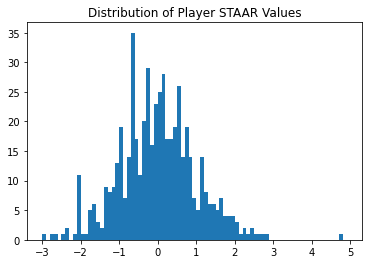

In [152]:
plt.hist(df['STAAR'], bins=np.arange(-3, 5, 0.1))
plt.title('Distribution of Player STAAR Values')
plt.show()